In [1]:
import sys

sys.path.append('./source/')
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, stats
import matplotlib.cm as cm
from numpy import fft
from scipy.interpolate import interp1d
import importlib
import json

from source import plots
from source import prob_dists as pd
from source.utils import read_param_file


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# plots.p1_plot({})

In [3]:
# plots.p1_slope_plot({})

In [4]:
importlib.reload(pd)
n = -1

params = {'R_G': 220, # Kpc
          'd_solar': 8.5, # kpc
          'psi': 40,
          'M_min': 1.0e-2, # Msun
          'M_max': 1.0e10, # Msun
          'fwimp': 1.0,
          'mean_params': {'a':77.4, 'b':0.87+0.31*n, 'c':-0.23-0.04*n},
          'nside': 128,
          'area_fermi': 2000.0, # cm^2
          'n': n,
          'log_flux_min': -14, # log10 photons/cm^2/yr
          'log_flux_max': -5, # log10 photons/cm^2/yr
          'N': 1000,
          'log_k_min': 2,
          'log_k_max': 14,
          'N_k': 25000,
          'psh_log_f_min': -9,
          'psh_log_f_max': -4,
          'N_psh': 500
         }

params['omega_pixel'] = 4.*np.pi/(12*params['nside']**2.) # sr
p = params
# json.dump(p, open('source/n-1.params', 'w'), indent=0)

In [5]:
p = read_param_file('source/n-1.params')
p

{'R_G': 220,
 'd_solar': 8.5,
 'psi': 40,
 'M_min': 0.01,
 'M_max': 10000000000.0,
 'fwimp': 1.0,
 'mean_params': {'a': 77.4, 'b': 0.56, 'c': -0.19},
 'nside': 128,
 'area_fermi': 6000.0,
 'n': -1,
 'log_flux_min': -13,
 'log_flux_max': -4,
 'N': 1000,
 'log_k_min': 0,
 'log_k_max': 13,
 'N_k': 150000,
 'psh_log_f_min': -12,
 'psh_log_f_max': -4,
 'N_psh': 500,
 'omega_pixel': 6.391586616190171e-05,
 'exposure': 5600.0}

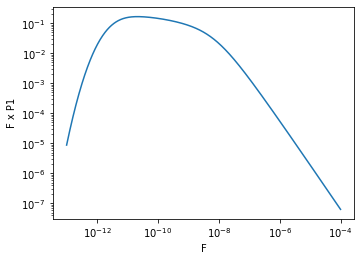

In [6]:
fluxes = np.logspace(p['log_flux_min'], p['log_flux_max'], num=p['N'])
p1_vals = pd.p1(fluxes, **p)
fig, _ = plots.check_fp1_plot(fluxes, p1_vals)

[1058870.35034894]


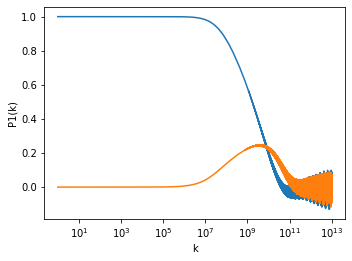

In [7]:
muu = pd.mu(**p)
print(muu)
muu = 1
ft_p1_vals, k = pd.ft_p1(p1_vals, fluxes, **p)
fig, _ = plots.check_ft_p1_plot(k, ft_p1_vals)


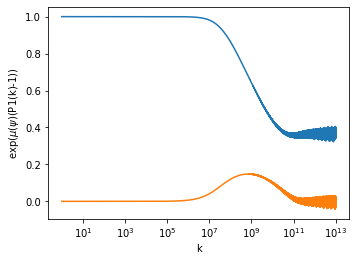

In [8]:
fig, _ = plots.check_psh_integrand_plot(k, ft_p1_vals, muu)

In [9]:
pf_vals, flux = pd.pf(muu, ft_p1_vals - np.exp(-muu), k, **p)

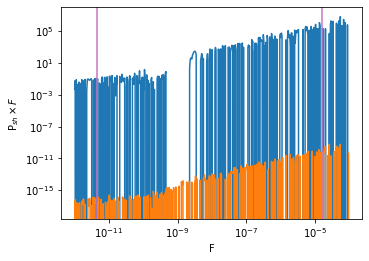

In [15]:
startl = 40
limi = -50
fig, ax = plots.check_psh_plot(flux, pf_vals, j=[startl, limi])
# ax.set_ylim(top=1, bottom=1e-6)

In [11]:
print(f'\mu \int F P1: {(muu * integrate.simps(fluxes * p1_vals, fluxes))}')
print(f' \int F Psh: {integrate.simps(pf_vals[startl:limi].real * flux[startl:limi], flux[startl:limi])}')


\mu \int F P1: 1.233492770676642e-09
 \int F Psh: 0.42736294272922165


In [12]:
np.save(f'./som_trial/trial_{p["N"]}_{p["N_k"]}.npy', pf_vals)

/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.8/site-packages/numpy/

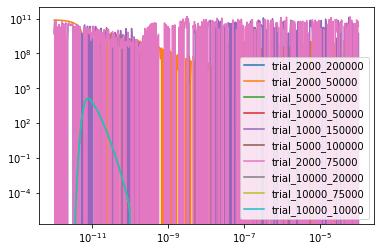

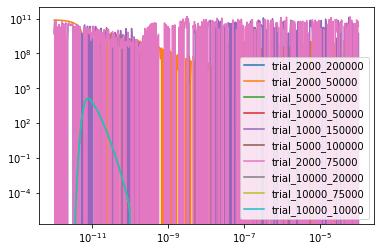

In [13]:
import glob
files = glob.glob('./som_trial/*.npy')
fig, ax = plt.subplots()
for fil in files:
    dat = np.load(fil)
    ax.plot(flux, dat, label=fil.strip('.npy').split('/')[-1])
    
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
fig

Got P1(F) values
inferred log_k_max 8.000000000002597
Finished FT of P1
0 500


ValueError: attempt to get argmax of an empty sequence

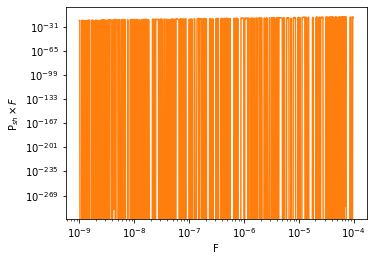

In [14]:
pshvals, fxs = pd.psh(params, plot=True, infer_values=True)

In [ ]:
plt.plot(fxs, fxs * pshvals.real)
ax = plt.gca()
startl = 0
limi = -1
ax.set_xscale('log')
ax.set_yscale('log')
ax.axvline(fxs[startl], color='b')
ax.axvline(fxs[limi], color='b')

print(f' \int F Psh: {integrate.simps(pshvals[startl:limi].real * fxs[startl:limi], fxs[startl:limi])}')


In [ ]:
numnum = 5
psis = np.linspace(40, 90, num=numnum)
colors = cm.viridis(np.linspace(0, 1, num=numnum))

fig, ax = plt.subplots()

psh_vals_over_psi = []

for psi, col in zip(psis, colors):
    p['psi'] = psi
    print('Angle:', psi)
    pshvals, fxs = pd.psh(params, plot=True, infer_values=True)
    
    psh_vals_over_psi.append((pshvals, fxs))
    
    ax.plot(fxs, fxs * pshvals.real, label=rf"{psi}$^\circ$", color=col)
   
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('F')
ax.set_ylabel('F x Psh')
cbarlabs = np.arange(min(psis), max(psis)+1, step=10)
cbar = fig.colorbar(cm.ScalarMappable(cmap=cm.viridis), ticks=np.linspace(0, 1, num=len(cbarlabs)))
cbar.set_label(r'$\psi$[$^\circ$]', rotation=270)
cbar.ax.set_yticklabels(cbarlabs)

In [ ]:
fig
fig.savefig('./output/psh_n-1.png')

In [ ]:
fig